----
# QDA classification using sklearn

----

In [701]:
%load_ext autoreload
%autoreload 2

from sklearn.metrics import confusion_matrix as skconfmatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Set correct working directory
if os.getcwd() != os.path.abspath("../Python"):
    os.chdir("../../Python")

# Import files from /Python directory
from confusion_matrix import confusion_matrix
"""
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr"
})
"""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'\nplt.rcParams.update({\n    "text.usetex": True,\n    "font.family": "cmr"\n})\n'

In [702]:
config = {
    "standardize" : True,
    "lda-reduce" : False,
    "classifier" : "qda",
    "keep_features" : 10,
}

In [703]:
# Load data sets
trn_data = pd.read_csv(f"../TrainingData/neodata/soltani_14d_nonoise_1200.csv")
vld_data = pd.read_csv(f"../ValidationData/neodata/soltani_14d_nonoise_1200.csv")
tst_data = pd.read_csv(f"../TestData/neodata/soltani_14d_nonoise_100.csv")

# Separate into data and targets
y_trn = trn_data.pop('target')
X_trn = trn_data#.assign(single=np.ones((len(y_trn),)))

y_vld = vld_data.pop('target')
X_vld = vld_data#.assign(single=np.ones((len(y_vld),)))

y_tst = tst_data.pop('target')
X_tst = tst_data#.assign(single=np.ones((len(y_tst),)))

## Standardize data (z-norm)

In [704]:

if config["standardize"]:
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    
    cols = X_trn.columns

    X_trn_std = standardizer.fit_transform(X_trn)
    X_vld_std = standardizer.transform(X_vld)
    X_tst_std = standardizer.transform(X_tst)

    X_trn_std = pd.DataFrame(X_trn_std,columns = cols)
    X_vld_std = pd.DataFrame(X_vld_std,columns = cols)
    X_tst_std = pd.DataFrame(X_tst_std,columns = cols)
else:
    X_trn_std = X_trn
    X_vld_std = X_vld
    X_tst_std = X_tst

In [721]:
def feature_conditioner(X):
    removal = []
    conditioning = [np.linalg.cond(X)]
    for _ in range(len(X.columns)-1):
        conds = {}
        for feature in X.columns:
            if feature not in removal:
                temp = removal.copy()
                temp.append(feature)
                conds[feature] = np.linalg.cond(X.drop(columns=temp))
        # print(f"{min(conds,key=conds.get)} : {conds}")
        removal.append(min(conds,key=conds.get))
        conditioning.append(np.linalg.cond(X.drop(columns=removal)))
    return removal,conditioning

def feature_conditioner_2(X,y):
    removal = []
    conditioning = [np.linalg.norm( [np.linalg.cond(X[y == c].cov()) for c in y.unique()])]
    for _ in range(len(X.columns)-1):
        conds = {}
        for feature in X.columns:
            if feature not in removal:
                temp = removal.copy()
                temp.append(feature)
                conds[feature] = np.linalg.norm( [np.linalg.cond(X[y == c].cov().drop(columns=temp)) for c in y.unique()])
        # print(f"{min(conds,key=conds.get)} : {conds}")
        removal.append(min(conds,key=conds.get))
        conditioning.append(np.linalg.norm( [np.linalg.cond(X[y == c].cov().drop(columns=removal)) for c in y.unique()]))
    return removal,conditioning


removal1,conditioning1 = feature_conditioner(X_trn_std)
removal2,conditioning2 = feature_conditioner_2(X_trn_std,y_trn)

removal,conditioning = feature_conditioner_2(X_trn_std,y_trn)

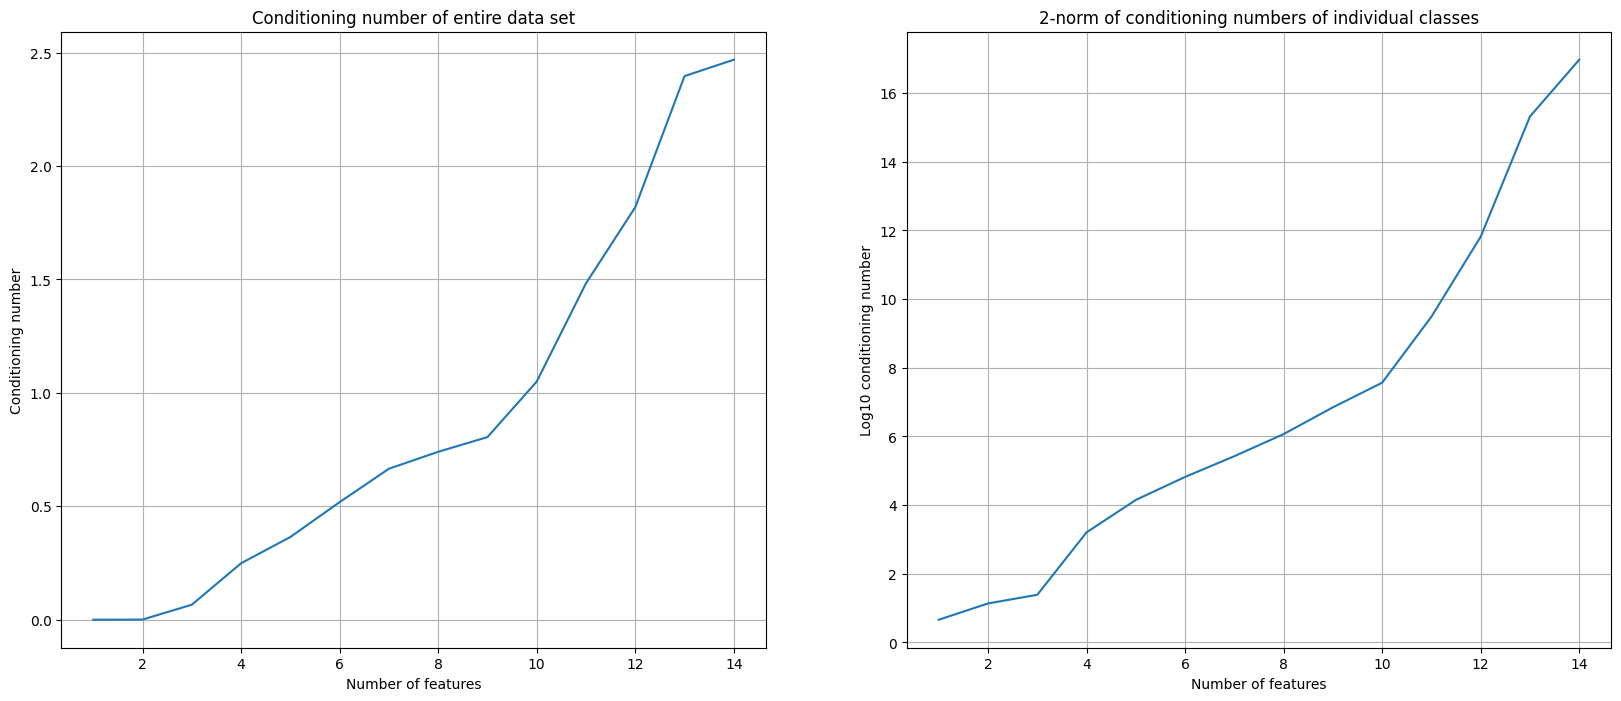

In [722]:
fig,(axs1,axs2) = plt.subplots(1,2,figsize = (20,8))
axs1.plot( np.flip([x for x in range(1,(len(conditioning)+1))]), np.log10(conditioning1) )
axs1.set_xlabel("Number of features")
axs1.set_ylabel("Conditioning number")
axs1.set_title("Conditioning number of entire data set")
axs1.grid()
axs2.plot( np.flip([x for x in range(1,(len(conditioning)+1))]), np.log10(conditioning2) )
axs2.set_xlabel("Number of features")
axs2.set_ylabel("Log10 conditioning number")
axs2.set_title("2-norm of conditioning numbers of individual classes")
axs2.grid()

In [707]:
if config["keep_features"] != False:
    X_trn_drop = X_trn_std.drop(columns = removal[0:14-config["keep_features"]])
    X_vld_drop = X_vld_std.drop(columns = removal[0:14-config["keep_features"]])
    X_tst_drop = X_tst_std.drop(columns = removal[0:14-config["keep_features"]])
    X_trn_drop.head()
else:
    X_trn_drop = X_trn_std
    X_vld_drop = X_vld_std
    X_tst_drop = X_tst_std

In [804]:
np.flip(np.sort(X_trn.columns))[0:8]

array(['Tsup', 'Tsuc', 'Tsh', 'Tset', 'Tret', 'Tdis', 'Tc', 'Tamb'],
      dtype=object)

In [794]:
features = ['Tc','Tdis','Tret','Tsuc','Tset','Density']
features = np.flip(np.sort(X_trn.columns))[0:8]

X_trn_drop = X_trn_std[features]
X_vld_drop = X_vld_std[features]
X_tst_drop = X_tst_std[features]

In [795]:

if config["lda-reduce"] != False:
    import lda
    reducer = lda.reducer(X_trn_std,y_trn,config["lda-reduce"])
    reducer = lda.reducer(X_trn_drop,y_trn,config["lda-reduce"])

    X_trn_red = reducer.transform(X_trn_drop)
    X_tst_red = reducer.transform(X_tst_drop)
    X_vld_red = reducer.transform(X_vld_drop)
else:
    X_trn_red = X_trn_drop
    X_tst_red = X_tst_drop
    X_vld_red = X_vld_drop

---

# Train classifiers

In [796]:
if config["classifier"] == "qda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
    clf = qda.fit(X_trn_red,y_trn)
    
elif config["classifier"] == "lda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.LinearDiscriminantAnalysis()
    clf = qda.fit(X_trn_red,y_trn)
    
elif config["classifier"] == "lda_self":
    import lda
    clf = lda.classifier(X_trn_red,y_trn)

elif config["classifier"] == "svm":
    from sklearn import svm
    clf = svm.SVC( C=1000, decision_function_shape="ovo", gamma=.01 )
    clf.fit(X_trn_red,y_trn)

/home/peterkrull/.local/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


# Classifying training data

In [797]:
str_feature = f"F{x}-" if (x:=config["keep_features"]) else ""
str_lda = f"LDA{x}-" if (x:=config["lda-reduce"]) else ""
str_classifier = str(config["classifier"]).upper()

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'F10-QDA of training set : Accuracy 96.079%'}, xlabel='Predicted class', ylabel='True class'>)

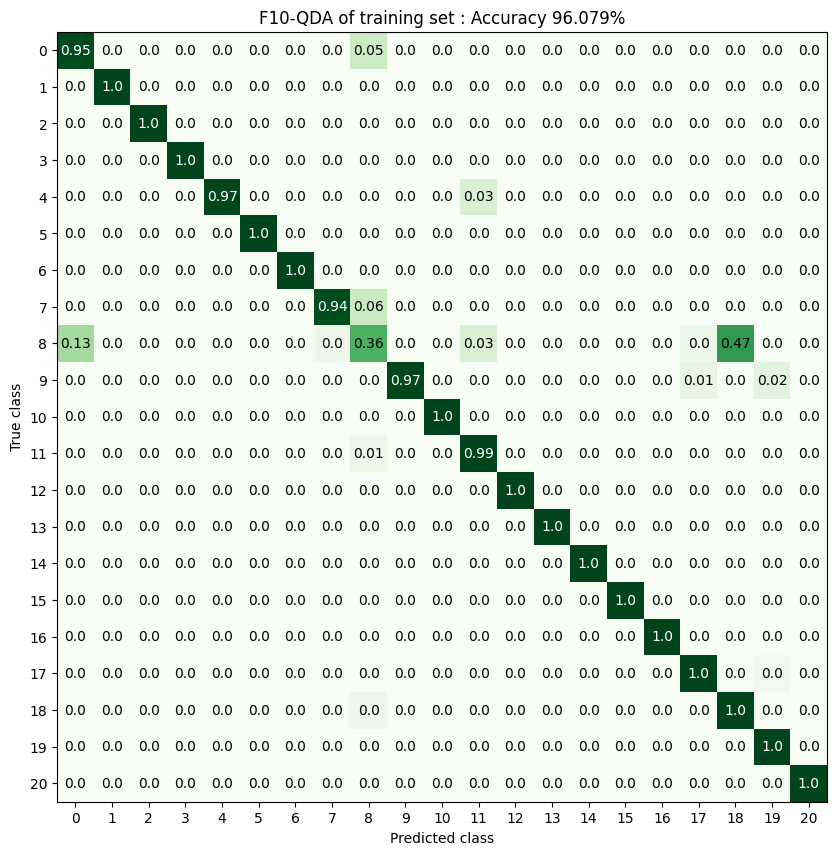

In [798]:
# Make predictions for the training set
y_hat_trn = clf.predict(X_trn_red)

#plot the confusion matrix
conf_matrix_trn = skconfmatrix(y_trn,y_hat_trn)
confusion_matrix(
    conf_matrix_trn,
    title = f'{str_feature}{str_lda}{str_classifier} of training set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-training.pdf')

# Classifying validation data

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'F10-QDA of validation set : Accuracy 95.913%'}, xlabel='Predicted class', ylabel='True class'>)

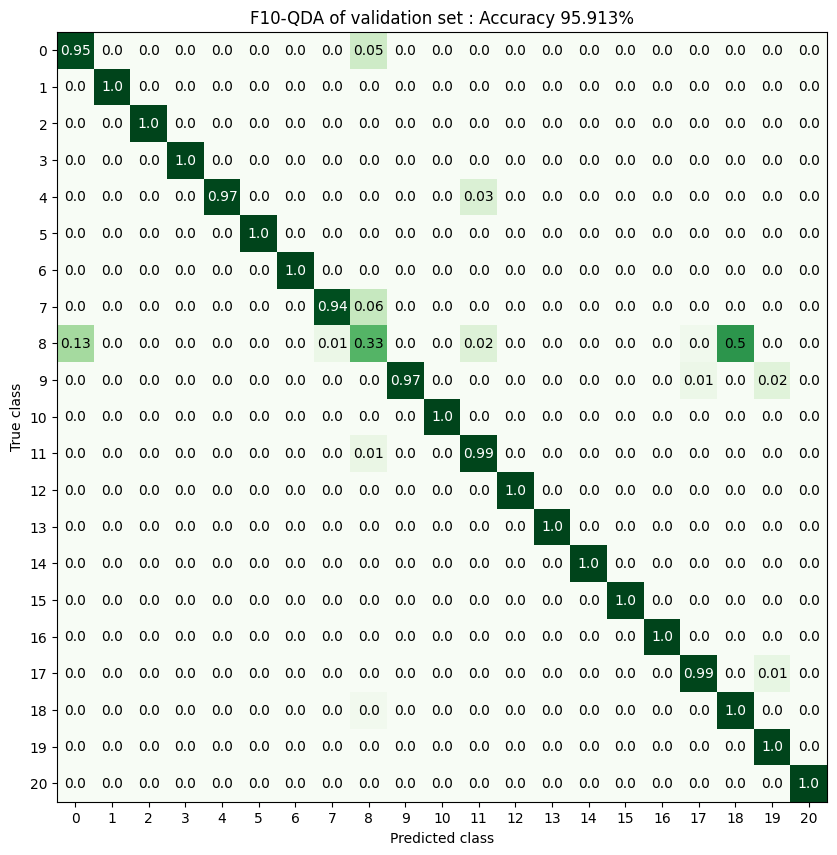

In [799]:
# Make predictions for the training set
y_hat_vld = clf.predict(X_vld_red)

#plot the confusion matrix
conf_matrix_vld = skconfmatrix(y_vld,y_hat_vld)
confusion_matrix(
    conf_matrix_vld,
    title = f'{str_feature}{str_lda}{str_classifier} of validation set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-validation.pdf')

# Classifying test data

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'F10-QDA of test set : Accuracy 85.714%'}, xlabel='Predicted class', ylabel='True class'>)

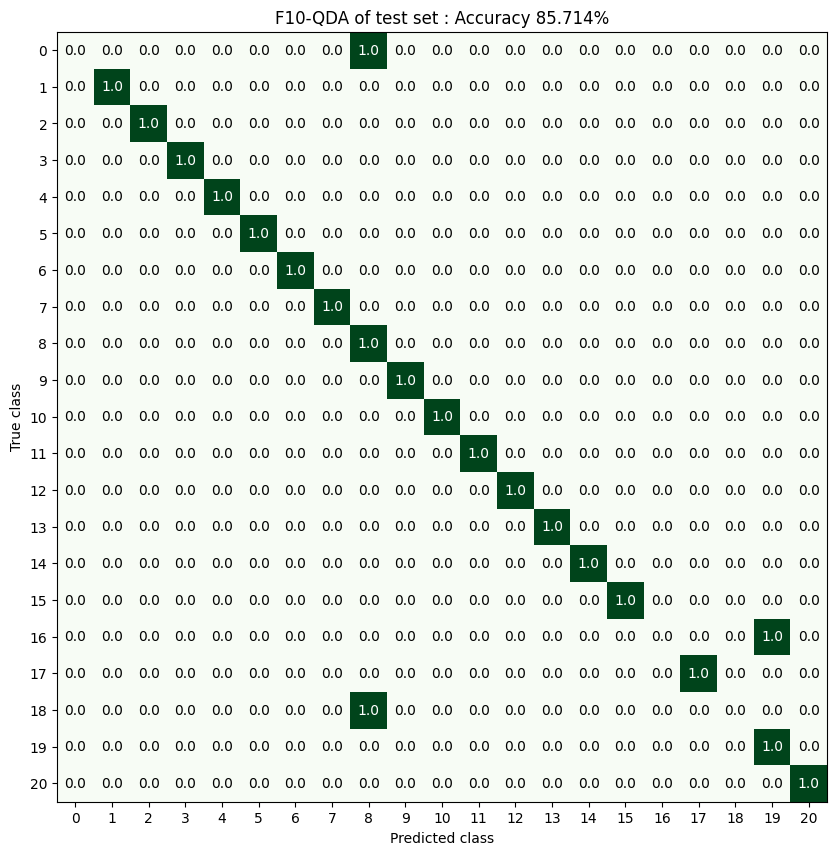

In [800]:
# Make predictions for the training set
y_hat_tst = clf.predict(X_tst_red)

#plot the confusion matrix
conf_matrix_tst = skconfmatrix(y_tst,y_hat_tst)
confusion_matrix(
    conf_matrix_tst,
    title = f'{str_feature}{str_lda}{str_classifier} of test set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-test.pdf')